Header files

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional,BatchNormalization,Flatten,Dropout,MaxPooling1D,Conv1D,Dense,LSTM,Dropout,multiply,Embedding,Concatenate,Input,Bidirectional,TimeDistributed
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Model
from keras import backend as K 
from datetime import datetime
from tensorflow.keras.models import model_from_json

Download dataset

In [3]:
!wget --header="Host: codeload.github.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://github.com/declare-lab/MELD" --header="Cookie: _octo=GH1.1.1355521219.1593976305; logged_in=no; _ga=GA1.2.1768389065.1593976308; _gat=1; tz=Asia%2FCalcutta" --header="Connection: keep-alive" "https://codeload.github.com/declare-lab/MELD/zip/master" -c -O 'MELD-master.zip'

--2020-07-11 02:44:54--  https://codeload.github.com/declare-lab/MELD/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘MELD-master.zip’

MELD-master.zip         [  <=>               ]   2.08M  7.15MB/s    in 0.3s    

2020-07-11 02:44:55 (7.15 MB/s) - ‘MELD-master.zip’ saved [2180995]



In [4]:
!unzip /content/MELD-master.zip

Archive:  /content/MELD-master.zip
677afb1ba7dadfeab3668322314d37ccce9b2bb2
   creating: MELD-master/
  inflating: MELD-master/LICENSE     
  inflating: MELD-master/README.md   
   creating: MELD-master/baseline/
  inflating: MELD-master/baseline/baseline.py  
  inflating: MELD-master/baseline/data_helpers.py  
   creating: MELD-master/data/
   creating: MELD-master/data/MELD/
  inflating: MELD-master/data/MELD/dev_sent_emo.csv  
  inflating: MELD-master/data/MELD/test_sent_emo.csv  
  inflating: MELD-master/data/MELD/train_sent_emo.csv  
   creating: MELD-master/data/MELD_Dyadic/
  inflating: MELD-master/data/MELD_Dyadic/dev_sent_emo_dya.csv  
  inflating: MELD-master/data/MELD_Dyadic/test_sent_emo_dya.csv  
  inflating: MELD-master/data/MELD_Dyadic/train_sent_emo_dya.csv  
   creating: MELD-master/data/emorynlp/
  inflating: MELD-master/data/emorynlp/emorynlp_dev_final.csv  
  inflating: MELD-master/data/emorynlp/emorynlp_test_final.csv  
  inflating: MELD-master/data/emorynlp/emoryn

In [5]:
train_data = pd.read_csv('/content/MELD-master/data/MELD/train_sent_emo.csv')
cv_data = pd.read_csv('/content/MELD-master/data/MELD/dev_sent_emo.csv')
test_data = pd.read_csv('/content/MELD-master/data/MELD/test_sent_emo.csv')

In [6]:
train_data.head(5)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [7]:
print(train_data.shape)
print(cv_data.shape)
print(test_data.shape)


(9989, 11)
(1109, 11)
(2610, 11)


In [8]:
train_data.Utterance.values[:100]

array(['also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.',
       'You must\x92ve had your hands full.', 'That I did. That I did.',
       'So let\x92s talk a little bit about your duties.',
       'My duties?  All right.',
       'Now you\x92ll be heading a whole division, so you\x92ll have a lot of duties.',
       'I see.',
       'But there\x92ll be perhaps 30 people under you so you can dump a certain amount on them.',
       'Good to know.', 'We can go into detail',
       'No don\x92t I beg of you!',
       'All right then, we\x92ll have a definite answer for you on Monday, but I think I can say with some confidence, you\x92ll fit in well here.',
       'Really?!', 'Absolutely.  You can relax',
       'But then who? The waitress I went out with last month?',
       'You know? Forget it!',
       'No-no-no-no, no! Who, who were you talking about?',
       "No, I-I-I-I don't, I actually don't know", 'Ok!',
       'All right, well...', 'Yeah, 

Preprocessing dataset

In [9]:
import re

In [10]:
def preprocess(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"\x92", "'",sentence)
    sentence = re.sub(r'[0-9\.]+', '',sentence)
    sentence = re.sub(r'\-',' ',sentence)
    sentence = re.sub(r' +', ' ',sentence)
    sentence = re.sub(r'[?!,.]','',sentence)
    sentence = re.sub(r"y'know",'you know',sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

I have not removed the stop words from data because many of the neutral utterance contains stop word only.

In [11]:
from tqdm import notebook

preprocess train

In [12]:
new_train=[]
for i in notebook.tqdm(train_data.Utterance.values):
  new_train.append(preprocess(i))
train_data['P_Utterance']=new_train

In [13]:
train_data['P_Utterance'].values[:100]

array(['also i was the point person on my company is transition from the kl to gr system',
       'you must have had your hands full', 'that i did that i did',
       'so let is talk a little bit about your duties',
       'my duties all right',
       'now you will be heading a whole division so you will have a lot of duties',
       'i see',
       'but there will be perhaps people under you so you can dump a certain amount on them',
       'good to know', 'we can go into detail', 'no don not i beg of you',
       'all right then we will have a definite answer for you on monday but i think i can say with some confidence you will fit in well here',
       'really', 'absolutely you can relax',
       'but then who the waitress i went out with last month',
       'you know forget it',
       'no no no no no who who were you talking about',
       'no i i i i don not i actually don not know', 'ok',
       'all right well', 'yeah sure', 'hey mon',
       'hey hey hey you wanna hear someth

preprocess cv

In [14]:
new_cv=[]
for i in notebook.tqdm(cv_data.Utterance.values):
  new_cv.append(preprocess(i))
cv_data['P_Utterance']=new_cv

preprocess test

In [15]:
new_test=[]
for i in notebook.tqdm(test_data.Utterance.values):
  new_test.append(preprocess(i))
test_data['P_Utterance']=new_test

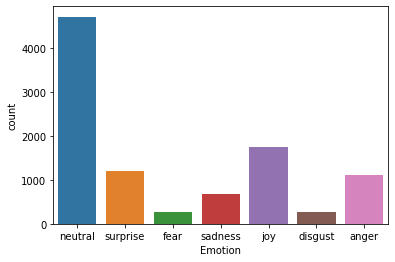

In [16]:
sn = sns.countplot(x=train_data['Emotion'], data=train_data)

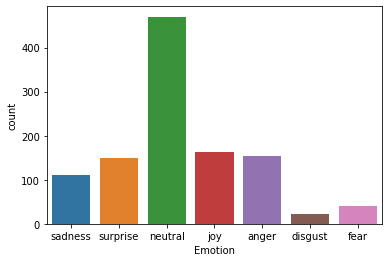

In [17]:
sn = sns.countplot(x=cv_data['Emotion'], data=cv_data)

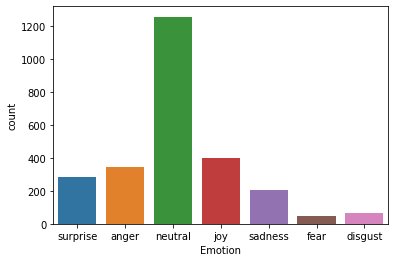

In [18]:
sn = sns.countplot(x=test_data['Emotion'], data=test_data)

In all the plots we can see that the data is highly imbalanced with most classes are neutral

In [19]:
s_len=[]
for i in train_data['P_Utterance'].values:
  word = i.split()
  s_len.append(len(word))


In [20]:
max(s_len)

72

Maximum length of utterance is 72

In [21]:
min(s_len)

0

Minimum length of utterance is 0

In [22]:
sum(s_len)/9989

8.581940134147562

Avg length of utterance is 8

In [23]:
count = 0
for i in s_len : 
    if i > 50 : 
        count = count + 1

In [24]:
count

1

Here we can see that only 1 utterence length is more then 50 so remove it.

In [25]:
s_len=[]
c=0
X_new = train_data
for i in train_data['P_Utterance']:
  word = i.split()
  c +=1
  if(len(word)==0 or len(word)>50):
    X_new=X_new.drop(X_new.index[c])
  

In [26]:
train_data.shape[0] - X_new.shape[0]

4

There are 4 utterence with 0 or more then 50 length and we have removed them

In [27]:
X_new = X_new.reset_index()

In [28]:
X_new

,index,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,P_Utterance
0,0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731",also i was the point person on my company is t...
1,1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442",you must have had your hands full
2,2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389",that i did that i did
3,3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572",so let is talk a little bit about your duties
4,4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917",my duties all right
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799",you or me
9981,9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594",i got it uh joey women don not have adam is ap...
9982,9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520",you guys are messing with me right
9983,9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274",yeah


In [29]:
X_train = X_new.P_Utterance
Y_train = X_new.Emotion
X_cv = cv_data.P_Utterance
Y_cv = cv_data.Emotion
X_test = test_data.P_Utterance
Y_test = test_data.Emotion

Creating the vocabulary of utterance words and padding the sentences 

In [31]:
t = Tokenizer()
t.fit_on_texts(X_train)
vocab_size = len(t.word_index) + 1 # for index zero we have to add +1  
encoded_docs_train = t.texts_to_sequences(X_train)
encoded_docs_test = t.texts_to_sequences(X_test)
encoded_docs_cv = t.texts_to_sequences(X_cv)
max_length = 50
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_length, padding='post')


In [110]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(t, handle)

with open('tokenizer.pickle', 'rb') as handle:
    b = pickle.load(handle)


Dowload glove vectors

In [32]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-data-sets/213609%2F464671%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1594643593&Signature=lwFPfhbKHiEL%2B0hmLCj8zFQOEtcmfuky78mUA4ouZi2w2bjBeqp3lyMXFkO50r00aD%2BefqbsR1j4BAAhxlfde47BscrI0cY1iweA4m7j5H72Jto5oqKmzpOaMKC%2FrSIQ5%2BikNtP%2BBgC2xayo94xhQLgwJUN8XTwD%2BACPMKuUXWLQMjh1H2orq8Q%2F9cpo2CrVAA4phaksewmn%2FxNGGOUML2E22cU60j6Hy7TwrrOoZImeiz%2FI3igsfBypX89AWVhT5yyGIFO%2BC1ag1gUQdMoYKdcXrpGeMi2Dn%2BwH21BZSdXbNHr8AspWBGXYkM1MY0u19qz7PM0x92HRVet%2BA2YV%2FQ%3D%3D" -c -O '213609_464671_bundle_archive.zip'

--2020-07-11 02:45:29--  https://storage.googleapis.com/kaggle-data-sets/213609%2F464671%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1594643593&Signature=lwFPfhbKHiEL%2B0hmLCj8zFQOEtcmfuky78mUA4ouZi2w2bjBeqp3lyMXFkO50r00aD%2BefqbsR1j4BAAhxlfde47BscrI0cY1iweA4m7j5H72Jto5oqKmzpOaMKC%2FrSIQ5%2BikNtP%2BBgC2xayo94xhQLgwJUN8XTwD%2BACPMKuUXWLQMjh1H2orq8Q%2F9cpo2CrVAA4phaksewmn%2FxNGGOUML2E22cU60j6Hy7TwrrOoZImeiz%2FI3igsfBypX89AWVhT5yyGIFO%2BC1ag1gUQdMoYKdcXrpGeMi2Dn%2BwH21BZSdXbNHr8AspWBGXYkM1MY0u19qz7PM0x92HRVet%2BA2YV%2FQ%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928408067 (1.8G) [application/zip]
Saving to: ‘213609_464671_bundle_archive.zip’

213609_464671_bundl 100%[===================>]   1.80G   139MB/s 

In [33]:
!unzip /content/213609_464671_bundle_archive.zip

Archive:  /content/213609_464671_bundle_archive.zip
  inflating: glove.42B.300d.txt      


In [34]:
from numpy import asarray
from tqdm import tqdm_notebook
embeddings_index = dict()
f = open('glove.42B.300d.txt')
for line in tqdm_notebook(f):
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [35]:
from numpy import zeros
input_matrix = zeros((vocab_size, 300))
for word, i in tqdm_notebook(t.word_index.items()):
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    input_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [113]:
with open('meld_inputmatrix.pickle', 'wb') as handle:
    pickle.dump(input_matrix, handle)

In [36]:
from sklearn import preprocessing

Preparing the label data

In [37]:
prep = preprocessing.LabelEncoder()
p_y_train = prep.fit_transform(Y_train)
p_y_cv = prep.transform(Y_cv)
p_y_test = prep.transform(Y_test)

In [114]:
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(prep, handle)

In [95]:
prep.classes_

array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness',
       'surprise'], dtype=object)

In [96]:
prep.transform(prep.classes_)

array([0, 1, 2, 3, 4, 5, 6])

In [100]:
label_dict = dict(zip(prep.transform(prep.classes_), prep.classes_ ))

In [38]:
p_y_train

array([4, 4, 4, ..., 6, 4, 3])

In [39]:
label_train = np_utils.to_categorical(p_y_train)
label_cv = np_utils.to_categorical(p_y_cv)
label_test = np_utils.to_categorical(p_y_test)

Modelling

CNN with Maxpooling,dropout and BatchNormalization

In [292]:
sequence_input = Input(shape=(50,))
embedding_layer = Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(256, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(2)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = Conv1D(64, 1, activation='relu')(x)
x = MaxPooling1D(2)(x)  
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(7, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              )
model.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 50, 300)           1696500   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 48, 256)           230656    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 24, 256)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 256)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 256)           1024      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 22, 128)           9843

In [295]:
model.fit(padded_docs_train, label_train, validation_data=(padded_docs_cv, label_cv),
          epochs=10, batch_size=64)


Train on 9985 samples, validate on 1109 samples
Epoch 1/10
9985/9985 [==============================] - 18s 2ms/step - loss: 1.2172 - val_loss: 1.4949
Epoch 2/10
9985/9985 [==============================] - 18s 2ms/step - loss: 1.2044 - val_loss: 1.4876
Epoch 3/10
9985/9985 [==============================] - 18s 2ms/step - loss: 1.1895 - val_loss: 1.4885
Epoch 4/10
9985/9985 [==============================] - 18s 2ms/step - loss: 1.1953 - val_loss: 1.4773
Epoch 5/10
9985/9985 [==============================] - 18s 2ms/step - loss: 1.1613 - val_loss: 1.5079
Epoch 6/10
9985/9985 [==============================] - 18s 2ms/step - loss: 1.1362 - val_loss: 1.5143
Epoch 7/10
9985/9985 [==============================] - 19s 2ms/step - loss: 1.1321 - val_loss: 1.5004
Epoch 8/10
9985/9985 [==============================] - 18s 2ms/step - loss: 1.1004 - val_loss: 1.5436
Epoch 9/10
9985/9985 [==============================] - 18s 2ms/step - loss: 1.1016 - val_loss: 1.5148
Epoch 10/10
9985/9985 [==

Modelling without Maxpooling

In [299]:
sequence_input = Input(shape=(50,))
embedding_layer = Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(256, 3, activation='relu')(embedded_sequences)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = Conv1D(128, 3, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = Conv1D(64, 1, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(7, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              )
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 50, 300)           1696500   
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 48, 256)           230656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 48, 256)           0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 48, 256)           1024      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 46, 128)           98432     
_________________________________________________________________
dropout_15 (Dropout)         (None, 46, 128)           0   

In [301]:
model.fit(padded_docs_train, label_train, validation_data=(padded_docs_cv, label_cv),
          epochs=10, batch_size=64)


Train on 9985 samples, validate on 1109 samples
Epoch 1/10
9985/9985 [==============================] - 28s 3ms/step - loss: 1.3150 - val_loss: 1.4801
Epoch 2/10
9985/9985 [==============================] - 28s 3ms/step - loss: 1.2868 - val_loss: 1.4970
Epoch 3/10
9985/9985 [==============================] - 28s 3ms/step - loss: 1.2831 - val_loss: 1.4960
Epoch 4/10
9985/9985 [==============================] - 28s 3ms/step - loss: 1.2495 - val_loss: 1.4872
Epoch 5/10
9985/9985 [==============================] - 28s 3ms/step - loss: 1.2363 - val_loss: 1.4629
Epoch 6/10
9985/9985 [==============================] - 28s 3ms/step - loss: 1.2105 - val_loss: 1.5160
Epoch 7/10
9985/9985 [==============================] - 27s 3ms/step - loss: 1.2006 - val_loss: 1.5049
Epoch 8/10
9985/9985 [==============================] - 28s 3ms/step - loss: 1.1712 - val_loss: 1.5182
Epoch 9/10
9985/9985 [==============================] - 28s 3ms/step - loss: 1.1479 - val_loss: 1.5351
Epoch 10/10
9985/9985 [==

In [115]:
sequence_input = Input(shape=(50,))
embedding_layer = Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)
embedded_sequences = embedding_layer(sequence_input)
x1 = Conv1D(32, 2)(embedded_sequences)
x2 = Conv1D(32, 2)(embedded_sequences)
x3 = Conv1D(32, 2)(embedded_sequences)
con = Concatenate()([x1,x2,x3])
pool1 = MaxPooling1D(2)(con)

x4 = Conv1D(16, 2)(pool1)
x5 = Conv1D(16, 2)(pool1)
x6 = Conv1D(16, 2)(pool1)
con = Concatenate()([x4,x5,x6])
pool2 = MaxPooling1D(2)(con)
x7 = Conv1D(32, 3)(pool2)
x = Flatten()(x7)
drop=Dropout(0.3)(x)
d1 = Dense(128,activation='relu')(drop)
d1 = Dropout(0.5)(d1)
preds = Dense(7,activation='softmax')(d1)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              )
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 50, 300)      1696500     input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 49, 32)       19232       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 49, 32)       19232       embedding_7[0][0]                
____________________________________________________________________________________________

In [116]:
model.fit(padded_docs_train, label_train, validation_data=(padded_docs_cv, label_cv),
          epochs=20, batch_size=64)

Train on 9985 samples, validate on 1109 samples
Epoch 1/20
9985/9985 [==============================] - 8s 757us/step - loss: 1.6003 - val_loss: 1.6149
Epoch 2/20
9985/9985 [==============================] - 7s 712us/step - loss: 1.4939 - val_loss: 1.5285
Epoch 3/20
9985/9985 [==============================] - 7s 720us/step - loss: 1.4033 - val_loss: 1.4894
Epoch 4/20
9985/9985 [==============================] - 7s 721us/step - loss: 1.3403 - val_loss: 1.4851
Epoch 5/20
9985/9985 [==============================] - 7s 728us/step - loss: 1.2564 - val_loss: 1.4866
Epoch 6/20
9985/9985 [==============================] - 7s 731us/step - loss: 1.1888 - val_loss: 1.5771
Epoch 7/20
9985/9985 [==============================] - 7s 733us/step - loss: 1.1350 - val_loss: 1.6175
Epoch 8/20
9985/9985 [==============================] - 7s 746us/step - loss: 1.0483 - val_loss: 1.6592
Epoch 9/20
9985/9985 [==============================] - 8s 753us/step - loss: 1.0061 - val_loss: 1.7359
Epoch 10/20
9985

CNN with LSTM 

In [123]:
sequence_input = Input(shape=(50,))
embedding_layer = Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(256, 3, activation='relu')(embedded_sequences)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = LSTM(128, dropout=0.3, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = LSTM(32, dropout=0.3, return_sequences=True)(x)
x = Dropout(0.5)(x)
x = Conv1D(64, 1, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(7, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              )
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 50, 300)           1696500   
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 48, 256)           230656    
_________________________________________________________________
dropout_55 (Dropout)         (None, 48, 256)           0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 48, 256)           1024      
_________________________________________________________________
lstm_26 (LSTM)               (None, 48, 128)           197120    
_________________________________________________________________
dropout_56 (Dropout)         (None, 48, 128)           0  

In [124]:
model.fit(padded_docs_train, label_train, validation_data=(padded_docs_cv, label_cv),
          epochs=20, batch_size=64)

Train on 9985 samples, validate on 1109 samples
Epoch 1/20
9985/9985 [==============================] - 56s 6ms/step - loss: 1.7342 - val_loss: 1.6451
Epoch 2/20
9985/9985 [==============================] - 55s 6ms/step - loss: 1.5701 - val_loss: 1.6273
Epoch 3/20
9985/9985 [==============================] - 55s 5ms/step - loss: 1.5419 - val_loss: 1.6607
Epoch 4/20
9985/9985 [==============================] - 54s 5ms/step - loss: 1.5342 - val_loss: 1.6271
Epoch 5/20
9985/9985 [==============================] - 54s 5ms/step - loss: 1.5206 - val_loss: 1.5881
Epoch 6/20
9985/9985 [==============================] - 55s 5ms/step - loss: 1.5096 - val_loss: 1.5639
Epoch 7/20
9985/9985 [==============================] - 54s 5ms/step - loss: 1.4990 - val_loss: 1.5856
Epoch 8/20
9985/9985 [==============================] - 55s 5ms/step - loss: 1.4737 - val_loss: 1.5672
Epoch 9/20
9985/9985 [==============================] - 55s 5ms/step - loss: 1.4605 - val_loss: 1.6432
Epoch 10/20
9985/9985 [==

Best model CNN with LSTM

In [52]:
sequence_input = Input(shape=(50,))
embedding_layer = Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(256, 3, activation='relu')(embedded_sequences)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = LSTM(64, dropout=0.3, return_sequences=True)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = Conv1D(64, 1, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(7, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              )
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 50, 300)           1696500   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 48, 256)           230656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 48, 256)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 256)           1024      
_________________________________________________________________
lstm_4 (LSTM)                (None, 48, 64)            82176     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 46, 128)           2470

In [53]:
from keras.callbacks import ModelCheckpoint
filepath="weights_email.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.fit(padded_docs_train, label_train, callbacks=callbacks_list,validation_data=(padded_docs_cv, label_cv),
          epochs=30, batch_size=64)


Train on 9985 samples, validate on 1109 samples
Epoch 1/30
9985/9985 [==============================] - 32s 3ms/step - loss: 1.6706 - val_loss: 1.6369

Epoch 00001: val_loss improved from inf to 1.63686, saving model to weights_email.h5
Epoch 2/30
9985/9985 [==============================] - 31s 3ms/step - loss: 1.5580 - val_loss: 1.6090

Epoch 00002: val_loss improved from 1.63686 to 1.60896, saving model to weights_email.h5
Epoch 3/30
9985/9985 [==============================] - 31s 3ms/step - loss: 1.5377 - val_loss: 1.5980

Epoch 00003: val_loss improved from 1.60896 to 1.59798, saving model to weights_email.h5
Epoch 4/30
9985/9985 [==============================] - 31s 3ms/step - loss: 1.5173 - val_loss: 1.5648

Epoch 00004: val_loss improved from 1.59798 to 1.56484, saving model to weights_email.h5
Epoch 5/30
9985/9985 [==============================] - 31s 3ms/step - loss: 1.4942 - val_loss: 1.6047

Epoch 00005: val_loss did not improve from 1.56484
Epoch 6/30
9985/9985 [=======

Modelling with lstms

In [333]:
from keras.models import Sequential
model = Sequential()
model.add(Embedding(vocab_size, 300,weights=[input_matrix],trainable=False))
model.add(LSTM(64, dropout=0.3, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, dropout=0.3, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(16, dropout=0.3, ))
model.add(Dropout(0.5))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(7,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, None, 300)         1696500   
_________________________________________________________________
lstm_44 (LSTM)               (None, None, 64)          93440     
_________________________________________________________________
dropout_44 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_45 (LSTM)               (None, None, 32)          12416     
_________________________________________________________________
dropout_45 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_46 (Dropout)         (None, 16)              

In [334]:
model.fit(padded_docs_train, label_train, validation_data=(padded_docs_cv, label_cv),
          epochs=10, batch_size=64)


Train on 9985 samples, validate on 1109 samples
Epoch 1/10
9985/9985 [==============================] - 26s 3ms/step - loss: 1.6401 - val_loss: 1.6335
Epoch 2/10
9985/9985 [==============================] - 24s 2ms/step - loss: 1.5692 - val_loss: 1.6298
Epoch 3/10
9985/9985 [==============================] - 24s 2ms/step - loss: 1.5642 - val_loss: 1.6284
Epoch 4/10
9985/9985 [==============================] - 24s 2ms/step - loss: 1.5558 - val_loss: 1.6266
Epoch 5/10
9985/9985 [==============================] - 24s 2ms/step - loss: 1.5443 - val_loss: 1.6056
Epoch 6/10
9985/9985 [==============================] - 24s 2ms/step - loss: 1.5300 - val_loss: 1.5930
Epoch 7/10
9985/9985 [==============================] - 24s 2ms/step - loss: 1.5157 - val_loss: 1.5861
Epoch 8/10
9985/9985 [==============================] - 24s 2ms/step - loss: 1.5079 - val_loss: 1.5780
Epoch 9/10
9985/9985 [==============================] - 24s 2ms/step - loss: 1.4963 - val_loss: 1.5620
Epoch 10/10
9985/9985 [==

Lstm with less no of parameters

In [47]:
from keras.models import Sequential
model1 = Sequential()
model1.add(Embedding(vocab_size, 300,weights=[input_matrix],trainable=False))
model1.add(LSTM(16, dropout=0.5, return_sequences=True))
model1.add(Dropout(0.5))
model1.add(LSTM(8, dropout=0.5))
model1.add(Dropout(0.5))



model1.add(Dense(100, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(7,activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam')
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 300)         1696500   
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 16)          20288     
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dropout_21 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               900       
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)              

In [49]:
model1.fit(padded_docs_train, label_train, validation_data=(padded_docs_cv, label_cv),
          epochs=10, batch_size=32)


Train on 9985 samples, validate on 1109 samples
Epoch 1/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.5039 - val_loss: 1.5919
Epoch 2/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.5009 - val_loss: 1.5771
Epoch 3/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.4944 - val_loss: 1.5781
Epoch 4/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.4898 - val_loss: 1.6065
Epoch 5/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.4857 - val_loss: 1.5532
Epoch 6/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.4837 - val_loss: 1.5537
Epoch 7/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.4844 - val_loss: 1.5452
Epoch 8/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.4803 - val_loss: 1.5496
Epoch 9/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.4738 - val_loss: 1.5673
Epoch 10/10
9985/9985 [==

Bidirectional Lstm

In [50]:
from keras.models import Sequential
model1 = Sequential()
model1.add(Embedding(vocab_size, 300,weights=[input_matrix],trainable=False))
model1.add(Bidirectional(LSTM(16, dropout=0.5, return_sequences=True)))
model1.add(Dropout(0.5))
model1.add(LSTM(8, dropout=0.5))
model1.add(Dropout(0.5))



model1.add(Dense(50, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(7,activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam')
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         1696500   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 32)          40576     
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 8)                 1312      
_________________________________________________________________
dropout_24 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                450       
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)               

In [51]:
model1.fit(padded_docs_train, label_train, validation_data=(padded_docs_cv, label_cv),
          epochs=10, batch_size=64)


Train on 9985 samples, validate on 1109 samples
Epoch 1/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.6850 - val_loss: 1.6397
Epoch 2/10
9985/9985 [==============================] - 13s 1ms/step - loss: 1.5817 - val_loss: 1.6250
Epoch 3/10
9985/9985 [==============================] - 13s 1ms/step - loss: 1.5535 - val_loss: 1.6058
Epoch 4/10
9985/9985 [==============================] - 13s 1ms/step - loss: 1.5386 - val_loss: 1.6053
Epoch 5/10
9985/9985 [==============================] - 12s 1ms/step - loss: 1.5273 - val_loss: 1.5907
Epoch 6/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.5212 - val_loss: 1.5817
Epoch 7/10
9985/9985 [==============================] - 14s 1ms/step - loss: 1.5194 - val_loss: 1.5880
Epoch 8/10
9985/9985 [==============================] - 12s 1ms/step - loss: 1.5117 - val_loss: 1.5779
Epoch 9/10
9985/9985 [==============================] - 13s 1ms/step - loss: 1.5083 - val_loss: 1.5669
Epoch 10/10
9985/9985 [==

Testing with best model

In [55]:
sequence_input = Input(shape=(50,))
embedding_layer = Embedding(vocab_size, 300,weights=[input_matrix],trainable=False)
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(256, 3, activation='relu')(embedded_sequences)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = LSTM(64, dropout=0.3, return_sequences=True)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = Conv1D(64, 1, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
preds = Dense(7, activation='softmax')(x)

model1 = Model(sequence_input, preds)
model1.load_weights("/content/weights_email.h5")
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              )
model1.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 50, 300)           1696500   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 48, 256)           230656    
_________________________________________________________________
dropout_16 (Dropout)         (None, 48, 256)           0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 256)           1024      
_________________________________________________________________
lstm_6 (LSTM)                (None, 48, 64)            82176     
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 46, 128)           2470

In [83]:
X = padded_docs_test
Y = label_test
scores = model1.evaluate(X, Y, verbose=0)

score we got after testing on best model

In [84]:
scores

1.408076105446651

In [104]:
a=model1.predict(X[:5]).argmax(axis=-1)

In [109]:
for i in a:
  print(label_dict[i])

neutral
neutral
neutral
neutral
neutral
